In [1]:
# ================================
# Step 0 — Project Setup
# ================================

import os
import random
import numpy as np
import tensorflow as tf

# Define project structure
project_dirs = ["data", "models", "notebooks", "src"]

for d in project_dirs:
    os.makedirs(d, exist_ok=True)

print("✅ Project structure created:", project_dirs)

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("✅ Seeds fixed to:", seed)

# Verify packages (if running fresh environment)
required_packages = [
    "numpy", "pandas", "scikit-learn", "tensorflow", 
    "nltk", "spacy", "sentence-transformers", "shap", "lime", "matplotlib"
]
print("📦 Suggested packages:", required_packages)


✅ Project structure created: ['data', 'models', 'notebooks', 'src']
✅ Seeds fixed to: 42
📦 Suggested packages: ['numpy', 'pandas', 'scikit-learn', 'tensorflow', 'nltk', 'spacy', 'sentence-transformers', 'shap', 'lime', 'matplotlib']


In [2]:
# ================================
# Step 1 — Generate / Collect Dataset
# ================================

import json
import pandas as pd
import numpy as np

# ---------- 1.2 Domain Requirements ----------
domain_requirements = {
    "Data Science": {
        "domain": "Data Science",
        "required_skills": [
            "Python", "Pandas", "NumPy", "Scikit-learn", "PyTorch", "Docker", "Deep Learning"
        ]
    },
    "Web Development": {
        "domain": "Web Development",
        "required_skills": [
            "HTML", "CSS", "JavaScript", "React", "Node.js", "Express", "SQL"
        ]
    },
    "Cloud Engineering": {
        "domain": "Cloud Engineering",
        "required_skills": [
            "AWS", "Azure", "Docker", "Kubernetes", "Linux", "Terraform", "CI/CD"
        ]
    }
}

# Save domain requirement files
os.makedirs("data/domain_requirements", exist_ok=True)
for domain, req in domain_requirements.items():
    with open(f"data/domain_requirements/{domain.lower().replace(' ','_')}.json", "w") as f:
        json.dump(req, f, indent=4)

print("✅ Domain requirement files saved.")


# ---------- 1.3 Synthetic Resume Generator ----------
skills_pool = list(set(sum([req["required_skills"] for req in domain_requirements.values()], []))) + [
    "C++", "Java", "SQL", "Tableau", "Hadoop", "Spark", "Flask"
]

job_titles = ["Data Scientist", "Data Analyst", "ML Engineer", "Backend Developer", "Frontend Developer", "Cloud Engineer"]

projects_pool = [
    "Image Classification using CNN", "Web Scraping with Python", "Portfolio Website",
    "Cloud Infrastructure Setup", "ETL Pipeline with Spark", "Dashboard with React"
]

def generate_resume(idx, domains):
    domain = np.random.choice(list(domains.keys()))
    required = domains[domain]["required_skills"]

    # Randomly sample skills
    n_skills = np.random.randint(3, 10)
    skills = list(np.random.choice(skills_pool, n_skills, replace=False))

    # Projects
    n_projects = np.random.randint(0, 4)
    projects = list(np.random.choice(projects_pool, n_projects, replace=False))

    # Work experience
    n_exp = np.random.randint(1, 3)
    work_experience = [
        {"title": np.random.choice(job_titles), "years": np.random.randint(0, 6)}
        for _ in range(n_exp)
    ]

    # Test score from clipped normal distribution (mean=65, std=20)
    test_score = int(np.clip(np.random.normal(65, 20), 0, 100))

    resume = {
        "id": f"candidate_{idx:04d}",
        "skills": skills,
        "projects": projects,
        "work_experience": work_experience,
        "test_score": test_score,
        "preferred_domain": domain
    }
    return resume


# Generate N=2000 synthetic resumes
N = 2000
synthetic_resumes = [generate_resume(i, domain_requirements) for i in range(N)]

# Save to JSON file
with open("data/synthetic_resumes.json", "w") as f:
    json.dump(synthetic_resumes, f, indent=4)

print(f"✅ Generated {N} synthetic resumes and saved to data/synthetic_resumes.json")

# Quick peek at one sample
print(json.dumps(synthetic_resumes[0], indent=2))

✅ Domain requirement files saved.
✅ Generated 2000 synthetic resumes and saved to data/synthetic_resumes.json
{
  "id": "candidate_0000",
  "skills": [
    "CI/CD",
    "PyTorch",
    "Azure",
    "SQL",
    "Terraform",
    "React"
  ],
  "projects": [
    "Image Classification using CNN",
    "ETL Pipeline with Spark"
  ],
  "work_experience": [
    {
      "title": "Cloud Engineer",
      "years": 2
    },
    {
      "title": "Backend Developer",
      "years": 3
    }
  ],
  "test_score": 54,
  "preferred_domain": "Cloud Engineering"
}


In [3]:
# ================================
# Step 2 — Create Ground Truth Labels (Rule-based)
# ================================

# Load domain requirements
domain_req_map = {}
for domain, req in domain_requirements.items():
    domain_req_map[domain] = set(req["required_skills"])

def assign_label(resume, domain_req_map):
    domain = resume["preferred_domain"]
    required_skills = domain_req_map[domain]
    candidate_skills = set(resume["skills"])

    # Matched & missing skills
    matched_skills = candidate_skills.intersection(required_skills)
    missing_skills = required_skills - candidate_skills

    # Ratios & counts
    skill_match_ratio = len(matched_skills) / len(required_skills) if required_skills else 0
    test_score_norm = resume["test_score"] / 100
    project_count = len(resume["projects"])

    # Apply labeling rules
    if (skill_match_ratio >= 0.70) and (test_score_norm >= 0.75) and (project_count >= 1):
        label = "Fit"
    elif (0.40 <= skill_match_ratio < 0.70) or (0.50 <= test_score_norm < 0.75):
        label = "Partial Fit"
    else:
        label = "Not Fit"

    # Add extra fields
    resume["matched_skills"] = list(matched_skills)
    resume["missing_skills"] = list(missing_skills)
    resume["skill_match_ratio"] = round(skill_match_ratio, 2)
    resume["test_score_norm"] = round(test_score_norm, 2)
    resume["project_count"] = project_count
    resume["label"] = label

    return resume


# Apply labeling to all resumes
labeled_resumes = [assign_label(r, domain_req_map) for r in synthetic_resumes]

# Save labeled dataset
with open("data/labeled_resumes.json", "w") as f:
    json.dump(labeled_resumes, f, indent=4)

print("✅ Rule-based labels assigned and saved to data/labeled_resumes.json")

# Quick distribution check
label_counts = pd.Series([r["label"] for r in labeled_resumes]).value_counts()
print("\nLabel Distribution:\n", label_counts)

# Peek at one labeled resume
print("\nSample Resume with Label:\n", json.dumps(labeled_resumes[0], indent=2))


✅ Rule-based labels assigned and saved to data/labeled_resumes.json

Label Distribution:
 Partial Fit    1170
Not Fit         827
Fit               3
Name: count, dtype: int64

Sample Resume with Label:
 {
  "id": "candidate_0000",
  "skills": [
    "CI/CD",
    "PyTorch",
    "Azure",
    "SQL",
    "Terraform",
    "React"
  ],
  "projects": [
    "Image Classification using CNN",
    "ETL Pipeline with Spark"
  ],
  "work_experience": [
    {
      "title": "Cloud Engineer",
      "years": 2
    },
    {
      "title": "Backend Developer",
      "years": 3
    }
  ],
  "test_score": 54,
  "preferred_domain": "Cloud Engineering",
  "matched_skills": [
    "Azure",
    "CI/CD",
    "Terraform"
  ],
  "missing_skills": [
    "Docker",
    "Kubernetes",
    "Linux",
    "AWS"
  ],
  "skill_match_ratio": 0.43,
  "test_score_norm": 0.54,
  "project_count": 2,
  "label": "Partial Fit"
}


In [4]:
# ================================
# Step A — Data Cleaning after Generation
# ================================

import re
from difflib import get_close_matches

# Canonical vocab (from domain requirements)
canonical_skills = sorted(set(sum([req["required_skills"] for req in domain_requirements.values()], [])))

# Stopwords for projects
stopwords = {"and", "the", "project", "using"}

# Canonical job titles
canonical_titles = ["data scientist", "data analyst", "machine learning engineer", "intern", 
                    "backend developer", "frontend developer", "cloud engineer"]

def normalize_skill(skill, canonical_vocab):
    s = skill.strip().lower()
    # Try exact canonical match
    if s in [c.lower() for c in canonical_vocab]:
        return s
    # Try fuzzy matching (closest skill)
    match = get_close_matches(s, [c.lower() for c in canonical_vocab], n=1, cutoff=0.8)
    if match:
        return match[0]
    return s   # keep as-is if no good match

def clean_projects(projects):
    cleaned = []
    for p in projects:
        p = p.lower()
        p = re.sub(r"[^a-z0-9 ]", " ", p)  # remove punctuation
        tokens = [t for t in p.split() if t not in stopwords]
        if len(tokens) >= 2:
            cleaned.append(" ".join(tokens))
    return list(set(cleaned))  # deduplicate

def normalize_title(title):
    t = title.lower().strip()
    match = get_close_matches(t, canonical_titles, n=1, cutoff=0.7)
    return match[0] if match else t

def clean_years(years):
    try:
        y = float(re.sub("[^0-9.]", "", str(years)))
        return max(y, 0)  # clamp negatives
    except:
        return 0

def clean_resume(resume):
    # Skills
    resume["skills"] = list({normalize_skill(s, canonical_skills) for s in resume["skills"]})
    
    # Projects
    resume["projects"] = clean_projects(resume["projects"])
    
    # Work experience
    cleaned_exp = []
    for exp in resume["work_experience"]:
        cleaned_exp.append({
            "title": normalize_title(exp["title"]),
            "years": clean_years(exp["years"])
        })
    resume["work_experience"] = cleaned_exp
    
    # Test score
    score = resume.get("test_score", 0)
    score = max(0, min(score, 100))  # clamp
    resume["test_score"] = int(score)
    resume["test_score_norm"] = round(score/100, 2)
    
    return resume

# Apply cleaning
cleaned_resumes = [clean_resume(r) for r in labeled_resumes]

# Remove corrupted/duplicates
seen = set()
final_resumes = []
for r in cleaned_resumes:
    key = (tuple(sorted(r["skills"])), tuple(r["projects"]), r["test_score"], r["preferred_domain"])
    if not r["skills"] and not r["projects"] and r["test_score"] == 0:
        continue  # drop corrupted
    if r["preferred_domain"] == "":
        continue
    if key in seen:
        continue
    seen.add(key)
    final_resumes.append(r)

print(f"✅ Cleaned dataset: {len(final_resumes)} resumes (from {len(labeled_resumes)})")

# Save cleaned data
with open("data/cleaned_resumes.json", "w") as f:
    json.dump(final_resumes, f, indent=4)


✅ Cleaned dataset: 2000 resumes (from 2000)


In [5]:
# ================================
# Step B — Label Balancing
# ================================

from collections import Counter
import random

labels = [r["label"] for r in final_resumes]
counts = Counter(labels)
print("Before balancing:", counts)

max_count = max(counts.values())
balanced_resumes = []

for label, count in counts.items():
    group = [r for r in final_resumes if r["label"] == label]
    if count < max_count:
        # Oversample minority
        extra = random.choices(group, k=max_count - count)
        balanced_resumes.extend(group + extra)
    else:
        balanced_resumes.extend(group)

balanced_counts = Counter([r["label"] for r in balanced_resumes])
print("After balancing:", balanced_counts)

# Save balanced dataset
with open("data/balanced_resumes.json", "w") as f:
    json.dump(balanced_resumes, f, indent=4)

Before balancing: Counter({'Partial Fit': 1170, 'Not Fit': 827, 'Fit': 3})
After balancing: Counter({'Partial Fit': 1170, 'Not Fit': 1170, 'Fit': 1170})


In [6]:
# ================================
# Step 3 — Preprocessing & Helper Functions
# ================================

import numpy as np
from sklearn.preprocessing import StandardScaler

# 3.1 Build skill vocabulary
def build_skill_vocab(resumes, domain_requirements):
    all_skills = set()
    for r in resumes:
        all_skills.update(r["skills"])
    for domain, req in domain_requirements.items():
        all_skills.update(req["required_skills"])
    skill_vocab = sorted(all_skills)
    return skill_vocab

skill_vocab = build_skill_vocab(final_resumes, domain_requirements)
skill_index = {s: i for i, s in enumerate(skill_vocab)}
skill_vocab_size = len(skill_vocab)

print(f"✅ Built skill vocabulary of size {skill_vocab_size}")


# 3.2 Skill encoding function
def encode_skills(candidate_skills, skill_index):
    vector = np.zeros(len(skill_index), dtype=int)
    for s in candidate_skills:
        if s in skill_index:
            vector[skill_index[s]] = 1
    return vector


# 3.3 Matched & missing skills
def matched_missing_skills(candidate_skills, domain_required_skills):
    candidate_set = set(candidate_skills)
    required_set = set(domain_required_skills)
    matched = list(candidate_set.intersection(required_set))
    missing = list(required_set - candidate_set)
    ratio = len(matched) / len(required_set) if required_set else 0
    return matched, missing, round(ratio, 2)


# 3.4 Project & experience features
def extract_project_experience_features(resume):
    project_count = len(resume.get("projects", []))
    years_experience = sum(item.get("years", 0) for item in resume.get("work_experience", []))
    return project_count, years_experience


# 3.5 Test score normalization
def normalize_test_score(score):
    return round(score / 100, 2)


# 3.6 Numeric feature scaling (fit & transform on dataset)
def fit_numeric_scalers(resumes):
    project_counts = []
    years_exp = []
    
    for r in resumes:
        p, y = extract_project_experience_features(r)
        project_counts.append(p)
        years_exp.append(y)
    
    project_scaler = StandardScaler()
    years_scaler = StandardScaler()
    
    project_scaler.fit(np.array(project_counts).reshape(-1, 1))
    years_scaler.fit(np.array(years_exp).reshape(-1, 1))
    
    return project_scaler, years_scaler

def transform_numeric_features(resume, project_scaler, years_scaler):
    project_count, years_exp = extract_project_experience_features(resume)
    project_scaled = project_scaler.transform([[project_count]])[0][0]
    years_scaled = years_scaler.transform([[years_exp]])[0][0]
    return project_scaled, years_scaled


# ================================
# ✅ Test the helper functions
# ================================
# Fit scalers on dataset
project_scaler, years_scaler = fit_numeric_scalers(final_resumes)

sample = final_resumes[0]

# Encode skills
skill_vector = encode_skills(sample["skills"], skill_index)

# Matched & missing
domain = sample["preferred_domain"]
matched, missing, ratio = matched_missing_skills(sample["skills"], domain_requirements[domain]["required_skills"])

# Numeric features
p_count, y_exp = extract_project_experience_features(sample)
p_scaled, y_scaled = transform_numeric_features(sample, project_scaler, years_scaler)

# Test score norm
score_norm = normalize_test_score(sample["test_score"])

print("\n=== Sample Resume Features ===")
print("Skill vector length:", len(skill_vector))
print("Matched:", matched)
print("Missing:", missing)
print("Skill match ratio:", ratio)
print("Project count:", p_count, "→ scaled:", round(p_scaled, 2))
print("Years experience:", y_exp, "→ scaled:", round(y_scaled, 2))
print("Normalized test score:", score_norm)


✅ Built skill vocabulary of size 46

=== Sample Resume Features ===
Skill vector length: 46
Matched: []
Missing: ['Linux', 'Kubernetes', 'Azure', 'Terraform', 'AWS', 'CI/CD', 'Docker']
Skill match ratio: 0.0
Project count: 2 → scaled: 0.43
Years experience: 5.0 → scaled: 0.5
Normalized test score: 0.54


In [7]:
# ================================
# Step 4 — Final Feature Vector
# ================================

import numpy as np

try:
    from sentence_transformers import SentenceTransformer
    sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
    use_embeddings = True
    print("✅ SBERT model loaded for text embeddings")
except ImportError:
    sbert_model = None
    use_embeddings = False
    print("⚠️ SentenceTransformer not installed — skipping text embeddings")


def build_final_vector(resume, domain_requirements, skill_index, 
                       project_scaler, years_scaler, use_embeddings=False):
    """
    Construct final feature vector for a single resume.
    """
    # 1. Skills branch
    skill_vector = encode_skills(resume["skills"], skill_index)  # binary
    domain = resume["preferred_domain"]
    matched, missing, ratio = matched_missing_skills(resume["skills"], domain_requirements[domain]["required_skills"])
    
    # Add skill_match_ratio as scalar numeric feature
    skill_features = np.append(skill_vector, ratio)

    # 2. Numeric branch
    project_count, years_exp = extract_project_experience_features(resume)
    project_scaled, years_scaled = transform_numeric_features(resume, project_scaler, years_scaler)
    test_score_norm = normalize_test_score(resume["test_score"])
    numeric_vector = np.array([test_score_norm, project_scaled, years_scaled, ratio])

    # 3. Optional text branch (project titles & job titles)
    if use_embeddings and sbert_model:
        project_titles = resume.get("projects", [])
        exp_titles = [exp["title"] for exp in resume.get("work_experience", [])]
        text_items = project_titles + exp_titles
        if text_items:
            project_embedding = np.mean(sbert_model.encode(text_items), axis=0)
        else:
            project_embedding = np.zeros(384)  # MiniLM embedding size
    else:
        project_embedding = np.array([])  # skip if not using embeddings

    # 4. Concatenate all branches
    final_vector = np.concatenate([skill_features, numeric_vector, project_embedding])
    return final_vector


# ================================
# ✅ Test on a sample resume
# ================================

sample = final_resumes[0]
final_vec = build_final_vector(sample, domain_requirements, skill_index, 
                               project_scaler, years_scaler, use_embeddings)

print("\n=== Final Vector Details ===")
print("Skill vector size:", len(skill_vocab))
print("Skill branch size (with ratio):", len(skill_vocab) + 1)
print("Numeric branch size:", 4)
if use_embeddings:
    print("Text branch size:", len(final_vec) - (len(skill_vocab) + 1 + 4))
else:
    print("Text branch skipped")
print("Final vector size:", len(final_vec))



✅ SBERT model loaded for text embeddings

=== Final Vector Details ===
Skill vector size: 46
Skill branch size (with ratio): 47
Numeric branch size: 4
Text branch size: 384
Final vector size: 435


In [8]:
# ================================
# Step 5 — Model Architecture
# ================================
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_resume_classifier(skill_vocab_size, numeric_size=4, text_embedding_size=None, learning_rate=1e-3):
    """
    Build a hybrid Keras model for resume classification.
    
    Args:
        skill_vocab_size: int → number of skills in vocabulary
        numeric_size: int → number of numeric features (default 4)
        text_embedding_size: int or None → dimension of text embedding if used
        learning_rate: float → learning rate for optimizer
    """
    # 5.1 Inputs
    skill_input = Input(shape=(skill_vocab_size,), name="skill_input")
    numeric_input = Input(shape=(numeric_size,), name="numeric_input")
    inputs = [skill_input, numeric_input]
    
    # Optional text input
    if text_embedding_size:
        project_input = Input(shape=(text_embedding_size,), name="project_input")
        inputs.append(project_input)
    else:
        project_input = None
    
    # 5.2 Skills branch
    x1 = Dense(256, activation="relu")(skill_input)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(128, activation="relu")(x1)
    
    # 5.3 Numeric branch
    x2 = Dense(32, activation="relu")(numeric_input)
    x2 = Dense(16, activation="relu")(x2)
    
    # 5.4 Project/text branch
    if project_input is not None:
        x3 = Dense(128, activation="relu")(project_input)
        x3 = Dense(64, activation="relu")(x3)
        concat = concatenate([x1, x2, x3])
    else:
        concat = concatenate([x1, x2])
    
    # 5.5 Concatenate → hidden layers
    h = Dense(128, activation="relu")(concat)
    h = Dropout(0.3)(h)
    h = Dense(64, activation="relu")(h)
    
    # 5.6 Output (3 classes: Fit, Partial Fit, Not Fit)
    out = Dense(3, activation="softmax", name="output")(h)
    
    # Build model
    model = Model(inputs=inputs, outputs=out)
    
    # 5.7 Compile
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"]
    )
    
    return model

# ================================
# ✅ Build model (without text embeddings for now)
# ================================
V = skill_vocab_size + 1   # skills + ratio
numeric_size = 4
text_embedding_size = None   # or 384 if using SBERT embeddings

model = build_resume_classifier(V, numeric_size, text_embedding_size)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ skill_input (InputLayer)      │ (None, 47)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │          12,288 │ skill_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 4)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 32)                │             160 │ numeric_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          32,896 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 16)                │             528 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 144)               │               0 │ dense_1[0][0],             │
│                               │                           │                 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │          18,560 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 64)                │           8,256 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output (Dense)                │ (None, 3)                 │             195 │ dense_5[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 72,883 (284.70 KB)

 Trainable params: 72,883 (284.70 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ================================
# Step 6 — Training Procedure
# ================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# -------------------------------
# Prepare dataset (features + labels)
# -------------------------------
def prepare_dataset(resumes, domain_requirements, skill_index, project_scaler, years_scaler, use_embeddings=False):
    X_skills, X_numeric, X_text, y = [], [], [], []
    
    for r in resumes:
        # Skill branch (skills + ratio already included in build_final_vector)
        skill_vector = encode_skills(r["skills"], skill_index)
        domain = r["preferred_domain"]
        _, _, ratio = matched_missing_skills(r["skills"], domain_requirements[domain]["required_skills"])
        skill_features = np.append(skill_vector, ratio)
        
        # Numeric branch
        project_scaled, years_scaled = transform_numeric_features(r, project_scaler, years_scaler)
        test_score_norm = normalize_test_score(r["test_score"])
        numeric_vector = np.array([test_score_norm, project_scaled, years_scaled, ratio])
        
        # Optional text branch
        if use_embeddings and sbert_model:
            project_titles = r.get("projects", [])
            exp_titles = [exp["title"] for exp in r.get("work_experience", [])]
            text_items = project_titles + exp_titles
            if text_items:
                project_embedding = np.mean(sbert_model.encode(text_items), axis=0)
            else:
                project_embedding = np.zeros(384)
        else:
            project_embedding = None
        
        X_skills.append(skill_features)
        X_numeric.append(numeric_vector)
        if use_embeddings:
            X_text.append(project_embedding)
        y.append(r["label"])
    
    X_skills = np.array(X_skills)
    X_numeric = np.array(X_numeric)
    if use_embeddings:
        X_text = np.array(X_text)
    else:
        X_text = None
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded, num_classes=3)
    
    return X_skills, X_numeric, X_text, y_onehot, label_encoder


# Load balanced dataset
with open("data/balanced_resumes.json", "r") as f:
    balanced_resumes = json.load(f)

X_skills, X_numeric, X_text, y, label_encoder = prepare_dataset(
    balanced_resumes, domain_requirements, skill_index, project_scaler, years_scaler, use_embeddings=False
)

# Train/val/test split (70/15/15 stratified)
X_train_s, X_temp_s, X_train_n, X_temp_n, y_train, y_temp = train_test_split(
    X_skills, X_numeric, y, test_size=0.30, stratify=y, random_state=42
)
X_val_s, X_test_s, X_val_n, X_test_n, y_val, y_test = train_test_split(
    X_temp_s, X_temp_n, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Train size: {len(X_train_s)}, Val size: {len(X_val_s)}, Test size: {len(X_test_s)}")

# -------------------------------
# Class weights
# -------------------------------
classes = np.argmax(y, axis=1)
class_weights = compute_class_weight("balanced", classes=np.unique(classes), y=classes)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# -------------------------------
# Callbacks
# -------------------------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("models/best_model.keras", save_best_only=True)
]

# -------------------------------
# Train model
# -------------------------------
history = model.fit(
    {"skill_input": X_train_s, "numeric_input": X_train_n},
    y_train,
    validation_data=({"skill_input": X_val_s, "numeric_input": X_val_n}, y_val),
    class_weight=class_weight_dict,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Train size: 2469, Val size: 529, Test size: 530
Class weights: {0: 1.0, 1: 1.0, 2: 1.0}
Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6541 - loss: 0.5846 - val_accuracy: 0.7032 - val_loss: 0.4592
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6825 - loss: 0.4640 - val_accuracy: 0.7013 - val_loss: 0.4540
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7278 - loss: 0.4523 - val_accuracy: 0.7183 - val_loss: 0.4498
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7363 - loss: 0.4411 - val_accuracy: 0.7410 - val_loss: 0.4456
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7456 - loss: 0.4355 - val_accuracy: 0.7335 - val_loss: 0.4467
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7618 - loss: 0.4239 - val_accuracy: 0.7467 - val_loss: 0.4431
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7736 - loss: 0.4098 - val_accuracy: 0.7240 - val_loss: 0.4495
Epoch 8/50
78/78 ━━━━━━━━━

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

=== Evaluation Metrics ===
Accuracy: 0.715
Precision: 0.715
Recall: 0.715
F1 Score: 0.714

Detailed Report:
               precision    recall  f1-score   support

         Fit       0.99      1.00      1.00       177
     Not Fit       0.58      0.51      0.54       177
 Partial Fit       0.57      0.64      0.60       176

    accuracy                           0.72       530
   macro avg       0.71      0.71      0.71       530
weighted avg       0.72      0.72      0.71       530



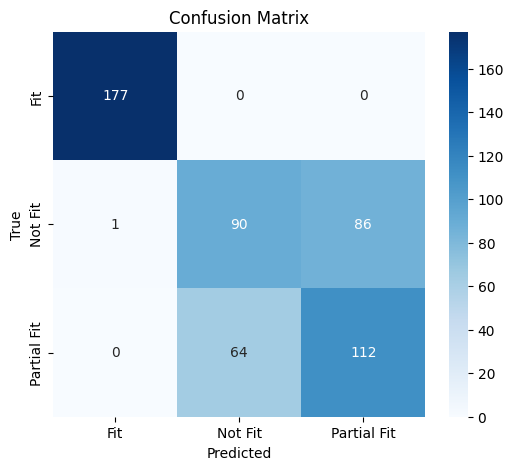

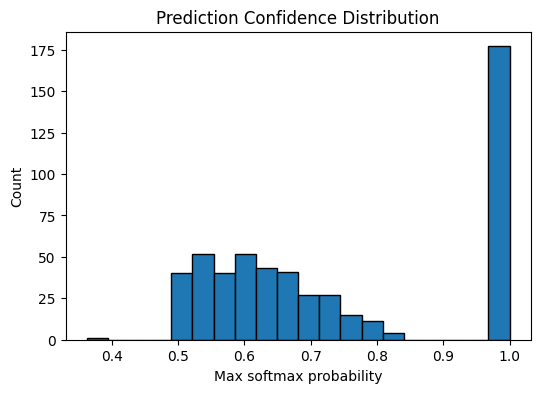

In [10]:
# ================================
# Step 7 — Metrics & Evaluation
# ================================
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
y_pred_probs = model.predict({"skill_input": X_test_s, "numeric_input": X_test_n})
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy, Precision, Recall, F1
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print("\n=== Evaluation Metrics ===")
print("Accuracy:", round(acc, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))
print("\nDetailed Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Calibration: predicted probability histogram
plt.figure(figsize=(6,4))
plt.hist(np.max(y_pred_probs, axis=1), bins=20, edgecolor="k")
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max softmax probability")
plt.ylabel("Count")
plt.show()


In [11]:
# ================================
# Step 8 — Interpretability & Explanation
# ================================

import numpy as np
import textwrap

# Helper: build flat vector used by model (same logic as Step 4)
def build_flat_vector_for_model(resume, skill_index, project_scaler, years_scaler, use_embeddings=False):
    # skill binary
    skill_vec = encode_skills(resume["skills"], skill_index)
    # matched ratio
    _, _, ratio = matched_missing_skills(resume["skills"], domain_requirements[resume["preferred_domain"]]["required_skills"])
    # append ratio to skill vector (as used earlier)
    skill_features = np.append(skill_vec, ratio).astype(float)
    # numeric vector (test_score_norm, project_scaled, years_scaled, ratio)
    project_count, years_exp = extract_project_experience_features(resume)
    project_scaled, years_scaled = transform_numeric_features(resume, project_scaler, years_scaler)
    test_score_norm = normalize_test_score(resume["test_score"])
    numeric_vector = np.array([test_score_norm, project_scaled, years_scaled, ratio], dtype=float)
    # final concatenation (no text embeddings here; if you used embeddings in training, extend accordingly)
    final = np.concatenate([skill_features, numeric_vector])
    return final, skill_features, numeric_vector, ratio

# Prediction wrapper: accepts single flat vector and returns softmax probs
def predict_from_flat_vector(flat_vec):
    # split back into inputs expected by the Keras model
    V_plus_ratio = len(skill_vocab) + 1  # same as during training: skill_vocab + ratio
    skill_input = flat_vec[:V_plus_ratio].reshape(1, -1)
    numeric_input = flat_vec[V_plus_ratio:V_plus_ratio + 4].reshape(1, -1)
    preds = model.predict({"skill_input": skill_input, "numeric_input": numeric_input}, verbose=0)
    return preds.flatten()

# Rule-based explanation template generator
def rule_based_explanation(resume, prob, label):
    matched, missing, ratio = matched_missing_skills(resume["skills"], domain_requirements[resume["preferred_domain"]]["required_skills"])
    project_count, years_exp = extract_project_experience_features(resume)
    raw_score = resume.get("test_score", None)
    score_norm = normalize_test_score(raw_score) if raw_score is not None else None
    top_missing = missing[:3] if missing else []
    
    lines = []
    lines.append(f"Predicted label: {label} (model confidence: {prob:.2f})")
    lines.append(f"Raw test score: {raw_score} / 100 (normalized: {score_norm:.2f})")
    lines.append(f"Skill match: {len(matched)} / {len(domain_requirements[resume['preferred_domain']]['required_skills'])} → ratio {ratio:.2f}")
    lines.append(f"Projects: {project_count}; Years experience (sum): {years_exp}")
    if top_missing:
        lines.append("Top missing required skills: " + ", ".join(top_missing))
    else:
        lines.append("No missing required skills (meets all listed domain requirements).")
    
    # Add quick recommendation
    recs = []
    if label != "Fit":
        if "PyTorch" in top_missing or "Deep Learning" in top_missing:
            recs.append("Add a Deep Learning project (PyTorch/TensorFlow).")
        if "Docker" in top_missing or "Kubernetes" in top_missing:
            recs.append("Add containerization (Docker) example or CI/CD step.")
        if len(resume.get("projects", [])) == 0:
            recs.append("Add at least one hands-on project demonstrating key skills.")
    if not recs:
        lines.append("Recommendation: Keep profile and add more high-impact projects to increase confidence.")
    else:
        lines.append("Recommendations: " + " ".join(recs))
    
    return "\n".join(lines)

# Optional: SHAP attribution (if shap installed). We use KernelExplainer on a small background subset.
def shap_explain(resume_flat, background_flat_array, feature_names=None, nsamples=100):
    try:
        import shap
    except Exception as e:
        print("SHAP not available:", e)
        return None
    
    # function that maps a 2D array of flat vectors -> model probabilities for each class (returns shape n x 3)
    def f(X):
        preds = []
        for row in X:
            preds.append(predict_from_flat_vector(row))
        return np.vstack(preds)
    
    explainer = shap.KernelExplainer(f, background_flat_array, link="identity")
    # explain original instance
    shap_values = explainer.shap_values(resume_flat, nsamples=nsamples)
    # shap_values is list length n_classes; each is array (1, n_features)
    return shap_values

# Sensitivity test: perturb test_score by +/- 10% and observe label/confidence changes
def sensitivity_test(resume, skill_index, project_scaler, years_scaler):
    base_flat, skill_features, numeric_vector, ratio = build_flat_vector_for_model(resume, skill_index, project_scaler, years_scaler)
    base_probs = predict_from_flat_vector(base_flat)
    base_label = label_encoder.inverse_transform([np.argmax(base_probs)])[0]
    # prepare perturbed resume copies
    perturbed_results = {}
    for pct in [-0.1, 0.1]:
        new_resume = dict(resume)  # shallow copy
        new_score = int(np.clip(resume.get("test_score",0) * (1 + pct), 0, 100))
        new_resume["test_score"] = new_score
        pert_flat, _, _, _ = build_flat_vector_for_model(new_resume, skill_index, project_scaler, years_scaler)
        probs = predict_from_flat_vector(pert_flat)
        label = label_encoder.inverse_transform([np.argmax(probs)])[0]
        perturbed_results[f"{int(pct*100)}%"] = {"test_score": new_score, "label": label, "confidence": float(np.max(probs))}
    return {
        "base": {"test_score": int(resume.get("test_score",0)), "label": base_label, "confidence": float(np.max(base_probs))},
        "perturbations": perturbed_results
    }

# Main explanation function combining everything
def explain_resume(resume, skill_index, project_scaler, years_scaler, background_resumes_for_shap=None, shap_nsamples=100, use_shap=False):
    # Build flat
    flat, _, _, _ = build_flat_vector_for_model(resume, skill_index, project_scaler, years_scaler)
    probs = predict_from_flat_vector(flat)
    pred_idx = int(np.argmax(probs))
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    pred_conf = float(np.max(probs))
    
    # Rule-based explanation
    rule_text = rule_based_explanation(resume, pred_conf, pred_label)
    
    # SHAP (optional)
    shap_result = None
    if use_shap:
        if background_resumes_for_shap is None:
            print("No background provided for SHAP; skipping SHAP.")
        else:
            # build background flat array (take up to 50)
            bg_flats = []
            for r in background_resumes_for_shap[:50]:
                bf, _, _, _ = build_flat_vector_for_model(r, skill_index, project_scaler, years_scaler)
                bg_flats.append(bf)
            bg_arr = np.vstack(bg_flats)
            sv = shap_explain(flat, bg_arr, nsamples=shap_nsamples)
            if sv is not None:
                # format top positive/negative contributors for predicted class
                class_shap = sv[pred_idx].flatten()  # shape (n_features,)
                # pair feature names: first V features are skill names + 'skill_match_ratio', then numeric features
                feat_names = skill_vocab + ["skill_match_ratio", "test_score_norm", "project_count_scaled", "years_experience_scaled", "skill_match_ratio_dup"]
                # Note: because we concatenated skill_features then numeric_vector, ensure names align; adjust if necessary.
                # We'll create simple top-K summary:
                top_k = 6
                idx_sorted = np.argsort(-np.abs(class_shap))[:top_k]
                contribs = []
                for i in idx_sorted:
                    name = feat_names[i] if i < len(feat_names) else f"f_{i}"
                    contribs.append((name, float(class_shap[i])))
                shap_result = contribs
    
    # Sensitivity
    sensitivity = sensitivity_test(resume, skill_index, project_scaler, years_scaler)
    borderline_flag = False
    if abs(sensitivity["base"]["confidence"] - np.max([v["confidence"] for v in sensitivity["perturbations"].values()])) > 0.2:
        borderline_flag = True
    
    # Compose final JSON-like explanation
    explanation = {
        "id": resume.get("id"),
        "predicted_label": pred_label,
        "predicted_confidence": pred_conf,
        "rule_based_explanation": rule_text,
        "matched_skills": resume.get("matched_skills", matched_missing_skills(resume["skills"], domain_requirements[resume["preferred_domain"]]["required_skills"])[0]),
        "missing_skills": resume.get("missing_skills", matched_missing_skills(resume["skills"], domain_requirements[resume["preferred_domain"]]["required_skills"])[1]),
        "feature_summary": {
            "skill_match_ratio": matched_missing_skills(resume["skills"], domain_requirements[resume["preferred_domain"]]["required_skills"])[2],
            "years_experience": sum([e.get("years",0) for e in resume.get("work_experience",[])]),
            "project_count": len(resume.get("projects",[])),
            "test_score": resume.get("test_score")
        },
        "sensitivity": sensitivity,
        "borderline_flag": borderline_flag,
        "shap_top_contributions": shap_result
    }
    return explanation

# ================================
# Example usage
# ================================

# Choose a sample resume from the cleaned/balanced dataset
sample_resume = balanced_resumes[0]   # or final_resumes[0], etc.

# Provide a small background list for SHAP (optional)
background = balanced_resumes[1:101] if len(balanced_resumes) > 101 else balanced_resumes[:50]

# Generate explanation (without SHAP)
explanation = explain_resume(sample_resume, skill_index, project_scaler, years_scaler, background_resumes_for_shap=background, use_shap=False)
print("\n--- Rule-based explanation (short) ---\n")
print("\n".join(textwrap.wrap(explanation["rule_based_explanation"], width=120)))

# If you have shap installed and want SHAP attribution (slower), set use_shap=True
# explanation_shap = explain_resume(sample_resume, skill_index, project_scaler, years_scaler, background_resumes_for_shap=background, shap_nsamples=100, use_shap=True)
# print("SHAP contributions:", explanation_shap["shap_top_contributions"])



--- Rule-based explanation (short) ---

Predicted label: Partial Fit (model confidence: 0.56) Raw test score: 54 / 100 (normalized: 0.54) Skill match: 0 / 7 →
ratio 0.00 Projects: 2; Years experience (sum): 5.0 Top missing required skills: Linux, Kubernetes, Azure
Recommendations: Add containerization (Docker) example or CI/CD step.


In [12]:
# ================================
# Step 9 — Postprocessing: Final JSON Output
# ================================

def build_final_output(resume, skill_index, project_scaler, years_scaler, label_encoder, use_shap=False):
    # Run explanation function (which also predicts)
    explanation = explain_resume(
        resume,
        skill_index,
        project_scaler,
        years_scaler,
        background_resumes_for_shap=None,
        use_shap=use_shap
    )
    
    # Format final JSON
    output_json = {
        "id": resume.get("id"),
        "label": explanation["predicted_label"],
        "confidence": round(explanation["predicted_confidence"], 3),
        "matched_skills": explanation["matched_skills"],
        "missing_skills": explanation["missing_skills"],
        "feature_summary": {
            "skill_match_ratio": round(explanation["feature_summary"]["skill_match_ratio"], 2),
            "years_experience": explanation["feature_summary"]["years_experience"],
            "test_score": round(explanation["feature_summary"]["test_score"] / 100, 2),  # normalized
            "project_count": explanation["feature_summary"]["project_count"]
        },
        "explanation": explanation["rule_based_explanation"]
    }
    
    return output_json


# Example usage with one candidate
sample_resume = balanced_resumes[0]
final_json = build_final_output(sample_resume, skill_index, project_scaler, years_scaler, label_encoder, use_shap=False)

import json
print("=== Final JSON Output ===")
print(json.dumps(final_json, indent=2))


=== Final JSON Output ===
{
  "id": "candidate_0000",
  "label": "Partial Fit",
  "confidence": 0.561,
  "matched_skills": [],
  "missing_skills": [
    "Linux",
    "Kubernetes",
    "Azure",
    "Terraform",
    "AWS",
    "CI/CD",
    "Docker"
  ],
  "feature_summary": {
    "skill_match_ratio": 0.0,
    "years_experience": 5.0,
    "test_score": 0.54,
    "project_count": 2
  },
  "explanation": "Predicted label: Partial Fit (model confidence: 0.56)\nRaw test score: 54 / 100 (normalized: 0.54)\nSkill match: 0 / 7 \u2192 ratio 0.00\nProjects: 2; Years experience (sum): 5.0\nTop missing required skills: Linux, Kubernetes, Azure\nRecommendations: Add containerization (Docker) example or CI/CD step."
}


In [13]:
# ================================
# Step 10 — Save Model & Artifacts
# ================================
import joblib

# Save model (TensorFlow SavedModel format)
# Save final model in .keras format
model.save("models/resume_classifier.keras")


# Save scalers
joblib.dump(project_scaler, "models/project_scaler.pkl")
joblib.dump(years_scaler, "models/years_scaler.pkl")

# Save skill vocabulary
with open("models/skill_vocab.json", "w") as f:
    json.dump(skill_vocab, f, indent=2)

# Save label encoder
joblib.dump(label_encoder, "models/label_encoder.pkl")

# Optional: save explanation templates or SHAP background set
# Optional: save explanation templates or SHAP background set
with open("models/explanation_template.txt", "w", encoding="utf-8") as f:
    f.write(
        "Template: High test score ({score}) and covers {matched}/{total} required skills. "
        "Missing {missing}. Projects: {projects}; Experience: {experience} years. "
        "Confidence: {confidence:.2f} → {label}."
    )


print("✅ Model & artifacts saved in 'models/' directory")


✅ Model & artifacts saved in 'models/' directory


In [14]:
# ================================
# Step 11 — Test New Resumes
# ================================

import json
import joblib
from tensorflow import keras
import numpy as np

# -------------------------------
# 1. Load saved artifacts
# -------------------------------
print("Loading model and artifacts...")
model = keras.models.load_model("models/resume_classifier.keras")
project_scaler = joblib.load("models/project_scaler.pkl")
years_scaler = joblib.load("models/years_scaler.pkl")
with open("models/skill_vocab.json", "r") as f:
    skill_vocab = json.load(f)
skill_index = {s: i for i, s in enumerate(skill_vocab)}
label_encoder = joblib.load("models/label_encoder.pkl")

print("✅ Artifacts loaded.")

# -------------------------------
# 2. Helper functions (from Step 3 & 4)
# -------------------------------

def encode_skills(candidate_skills, skill_index):
    vector = np.zeros(len(skill_index), dtype=int)
    for s in candidate_skills:
        if s in skill_index:
            vector[skill_index[s]] = 1
    return vector

def matched_missing_skills(candidate_skills, domain_required_skills):
    candidate_set = set(candidate_skills)
    required_set = set(domain_required_skills)
    matched = list(candidate_set.intersection(required_set))
    missing = list(required_set - candidate_set)
    ratio = len(matched) / len(required_set) if required_set else 0
    return matched, missing, round(ratio, 2)

def extract_project_experience_features(resume):
    project_count = len(resume.get("projects", []))
    years_experience = sum(item.get("years", 0) for item in resume.get("work_experience", []))
    return project_count, years_experience

def normalize_test_score(score):
    return round(score / 100, 2)

def transform_numeric_features(resume, project_scaler, years_scaler):
    project_count, years_exp = extract_project_experience_features(resume)
    project_scaled = project_scaler.transform([[project_count]])[0][0]
    years_scaled = years_scaler.transform([[years_exp]])[0][0]
    return project_scaled, years_scaled

# -------------------------------
# 3. Build final vector & predict
# -------------------------------

def build_flat_vector(resume, skill_index, project_scaler, years_scaler, domain_requirements):
    skill_vec = encode_skills(resume["skills"], skill_index)
    domain = resume["preferred_domain"]
    _, _, ratio = matched_missing_skills(resume["skills"], domain_requirements[domain]["required_skills"])
    skill_features = np.append(skill_vec, ratio).astype(float)

    project_scaled, years_scaled = transform_numeric_features(resume, project_scaler, years_scaler)
    test_score_norm = normalize_test_score(resume.get("test_score", 0))
    numeric_vector = np.array([test_score_norm, project_scaled, years_scaled, ratio], dtype=float)

    flat_vector = np.concatenate([skill_features, numeric_vector])
    return flat_vector

def predict_resume(resume, domain_requirements):
    flat = build_flat_vector(resume, skill_index, project_scaler, years_scaler, domain_requirements)
    V_plus_ratio = len(skill_vocab) + 1
    skill_input = flat[:V_plus_ratio].reshape(1, -1)
    numeric_input = flat[V_plus_ratio:V_plus_ratio + 4].reshape(1, -1)
    probs = model.predict({"skill_input": skill_input, "numeric_input": numeric_input}, verbose=0)
    pred_idx = int(np.argmax(probs))
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    confidence = float(np.max(probs))
    matched, missing, _ = matched_missing_skills(resume["skills"], domain_requirements[resume["preferred_domain"]]["required_skills"])
    project_count, years_exp = extract_project_experience_features(resume)
    return {
        "id": resume.get("id"),
        "label": pred_label,
        "confidence": round(confidence, 3),
        "matched_skills": matched,
        "missing_skills": missing,
        "feature_summary": {
            "skill_match_ratio": round(len(matched) / len(domain_requirements[resume["preferred_domain"]]["required_skills"]), 2),
            "years_experience": years_exp,
            "test_score": round(normalize_test_score(resume.get("test_score", 0)), 2),
            "project_count": project_count
        }
    }

# -------------------------------
# 4. Load new resumes dataset
# -------------------------------
with open("data/new_resumes.json", "r") as f:
    new_resumes = json.load(f)

# Replace this with your actual domain requirements
with open("data/domain_requirements/data_science.json") as f:
    data_science_req = json.load(f)
with open("data/domain_requirements/web_development.json") as f:
    web_req = json.load(f)
with open("data/domain_requirements/cloud_engineering.json") as f:
    cloud_req = json.load(f)
domain_requirements = {
    "Data Science": data_science_req,
    "Web Development": web_req,
    "Cloud Engineering": cloud_req
}

# -------------------------------
# 5. Predict & save
# -------------------------------
results = []
for resume in new_resumes:
    output = predict_resume(resume, domain_requirements)
    results.append(output)

with open("data/predictions.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"✅ Predictions completed for {len(results)} resumes and saved to data/predictions.json")


Loading model and artifacts...
✅ Artifacts loaded.
✅ Predictions completed for 5 resumes and saved to data/predictions.json


In [15]:
# ================================
# Step 11 — Test New Resumes (with explanations)
# ================================

import json
import joblib
from tensorflow import keras

# -------------------------------
# 1. Load saved artifacts
# -------------------------------
print("Loading model and artifacts...")
model = keras.models.load_model("models/resume_classifier.keras")
project_scaler = joblib.load("models/project_scaler.pkl")
years_scaler = joblib.load("models/years_scaler.pkl")
with open("models/skill_vocab.json", "r") as f:
    skill_vocab = json.load(f)
skill_index = {s: i for i, s in enumerate(skill_vocab)}
label_encoder = joblib.load("models/label_encoder.pkl")
print("✅ Artifacts loaded.")

# -------------------------------
# 2. Load new resumes dataset
# -------------------------------
with open("data/new_resumes.json", "r") as f:
    new_resumes = json.load(f)

# Load domain requirements
with open("data/domain_requirements/data_science.json") as f:
    data_science_req = json.load(f)
with open("data/domain_requirements/web_development.json") as f:
    web_req = json.load(f)
with open("data/domain_requirements/cloud_engineering.json") as f:
    cloud_req = json.load(f)

domain_requirements = {
    "Data Science": data_science_req,
    "Web Development": web_req,
    "Cloud Engineering": cloud_req
}

# -------------------------------
# 3. Predict & build final JSON output
# -------------------------------
results = []
for resume in new_resumes:
    output_json = build_final_output(
        resume,
        skill_index,
        project_scaler,
        years_scaler,
        label_encoder,
        use_shap=False  # set True if SHAP is installed and desired
    )
    results.append(output_json)

# -------------------------------
# 4. Save predictions
# -------------------------------
with open("data/predictions.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"✅ Predictions with explanations completed for {len(results)} resumes and saved to data/predictions.json")


Loading model and artifacts...
✅ Artifacts loaded.
✅ Predictions with explanations completed for 5 resumes and saved to data/predictions.json
